[['Western honeybee'], ['Russels viper'], ['American alligator'], ['African bush elephant', 'American beaver', 'American black bear', 'Asian black bear', 'Bonobo', 'Brown rat', 'Cattle', 'Cheetah', 'Chimpanzee', 'Chipmunk', 'Cougar', 'Dingo', 'Dog', 'Dolphin', 'Domestic Cat', 'Domestic Yak', 'Eastern gray kangaroo', 'Eastern wolf', 'Fox squirrel', 'Giant panda', 'Gorilla', 'Guinea pig', 'Horse', 'House mouse', 'Human', 'Hyaena', 'Indian rhinoceros', 'Indian wolf', 'Koala', 'Malayan porcupine', 'Neanderthal', 'Northern giraffe', 'Ocelot', 'Orangutan', 'Platypus', 'Polar bear', 'Red fox', 'Reindeer', 'Tiger', 'Virginia opossum', 'Wallaby', 'White rhinoceros', 'White-tailed deer', 'Wild boar'], ['Alpine newt', 'Chinese giant salamander', 'Eastern newt', 'Edible frog', 'Fire salamander', 'Fugu rubripes', 'Goldfish', 'Gray treefrog', 'Great white shark'], ['American robin', 'Bald Eagle', 'Cardinal', 'Eurasian eagle-owl', 'Eurasian golden oriole', 'Mourning dove'], ['Chameleon'], ['Bearded D

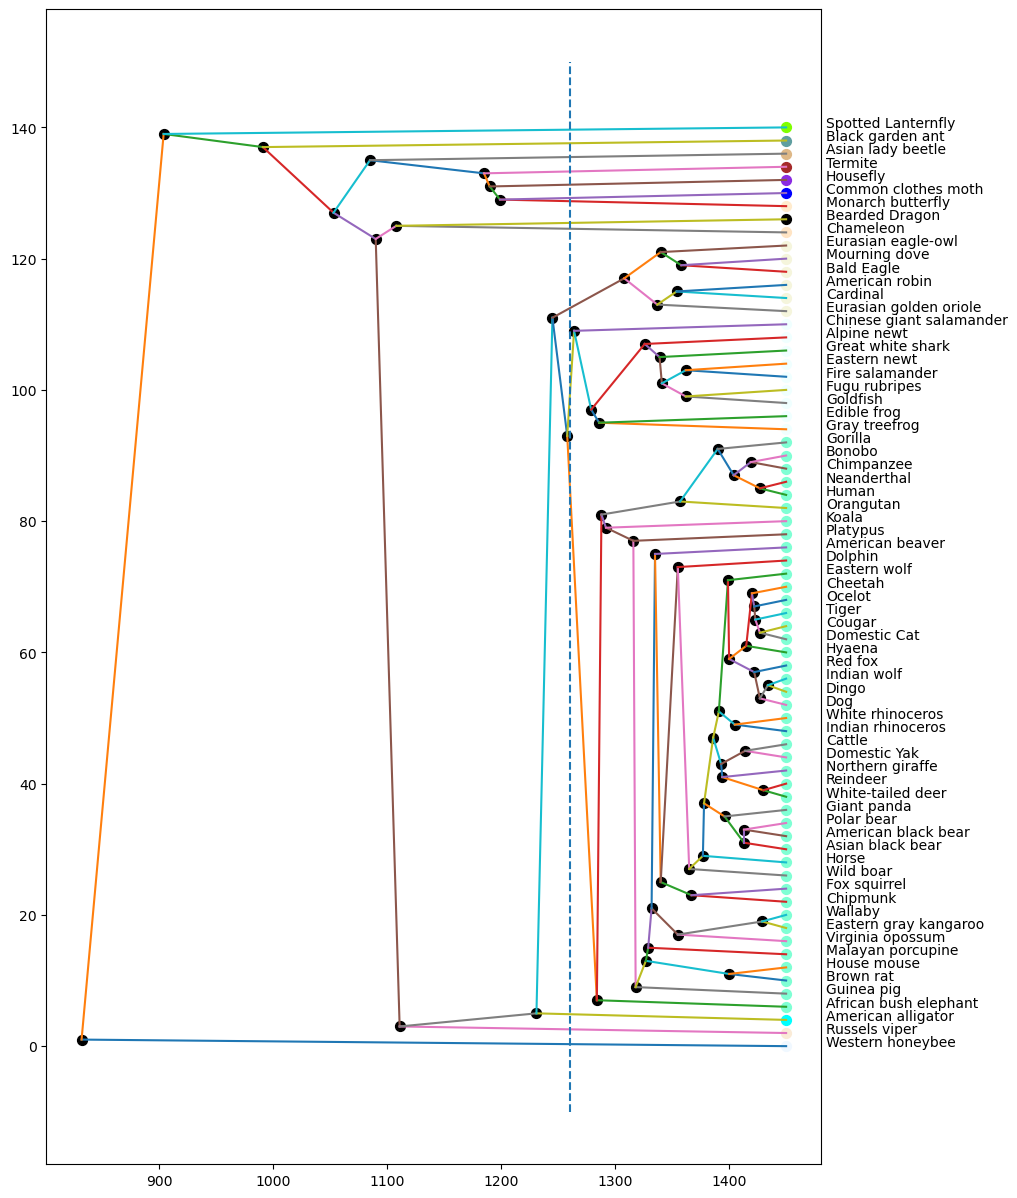

In [57]:
import numpy as np
import matplotlib.pyplot as plt
import json
from pandas import *
import unionrankpc as djs
import matplotlib.colors as mcolors
            


def load_blosum(filename):
    """
    Load in a BLOSUM scoring matrix for Needleman-Wunsch

    Parameters
    ----------
    filename: string
        Path to BLOSUM file
    
    Returns
    -------
    A dictionary of {string: int}
        Key is string, value is score for that particular 
        matching/substitution/deletion
    """
    fin = open(filename)
    lines = [l for l in fin.readlines() if l[0] != "#"]
    fin.close()
    symbols = lines[0].split()
    X = [[int(x) for x in l.split()] for l in lines[1::]]
    X = np.array(X, dtype=int)
    N = X.shape[0]
    costs = {}
    for i in range(N-1):
        for j in range(i, N):
            c = X[i, j]
            if j == N-1:
                costs[symbols[i]] = c
            else:
                costs[symbols[i]+symbols[j]] = c
                costs[symbols[j]+symbols[i]] = c
    return costs

def needleman_wunsch(s1, s2, costs):
    n = len(s1)
    m = len(s2)

    # make an empty array
    mem = np.zeros((n + 1, m + 1), dtype=int)
 
    # fill in the base cases 
    for i in range(1, m + 1):
        mem[0, i] = mem[0, i - 1] + costs[s2[i-1]]
            
    for i in range(1, n + 1):
        mem[i, 0] = mem[i - 1, 0] + costs[s1[i-1]]

    for i in range(1, n + 1):
        for j in range(1, m + 1):
            mem[i, j] = max(mem[i-1, j-1] + costs[s1[i-1]+s2[j-1]], mem[i-1, j] + costs[s1[i-1]], mem[i, j-1] + costs[s2[j-1]])
    #print(DataFrame(mem)) 
    return int(mem[-1, -1])

def needleman_wunsch_all_pairs(species, costs):
    keys = list(species.keys())

    data = {}

    for i in range(len(keys)):
        for j in range(i+1, len(keys)):
            data[keys[i] + "," + keys[j]] = needleman_wunsch(species[keys[i]], species[keys[j]], costs)
    return data

def sorted_data():
    loaded_data = json.load(open("distances.json"))['data']
    sorted_data = sorted(loaded_data.items(), key=lambda x:x[1])
    sorted_data.reverse()
    return sorted_data

class treeNode:

    def __init__(self, value, animal):
        self.left = None
        self.right = None
        self.value = value
        self.animal = animal
        self.parent = None
        self.inorder_pos = 0
        self.cluster = None
    
    def inorder(self, num, key_list):
        if self.left:
            self.left.inorder(num, key_list)
        self.inorder_pos = num[0]
        if self.animal:
            key_list.append((self.animal))
        num[0] += 1
        if self.right:
            self.right.inorder(num, key_list)
            
    def get_root(self):
        cursor = self
        while cursor.parent:
            cursor = cursor.parent
        return cursor
    
    def draw(self):
        if self.value == 0:
            x = 1450
        else:   
            x = self.value
        y = self.inorder_pos
        plt.scatter([x], [y], 50, 'k')
        if self.animal:
            plt.text(x+35, y, "{}".format(self.animal))
        if self.left:
            x_next = self.left.value
            if x_next == 0:
                x_next = 1450
            y_next = self.left.inorder_pos
            plt.plot([x, x_next], [y, y_next])
            self.left.draw()
        if self.right:
            x_next = self.right.value
            if x_next == 0:
                x_next = 1450
            y_next = self.right.inorder_pos
            plt.plot([x, x_next], [y, y_next])
            self.right.draw()
            
    def draw_clusters(self, colors):
        if self.value == 0:
            x = 1450
        else:   
            x = self.value
        y = self.inorder_pos
        if self.animal:
            plt.text(x+35, y, "{}".format(self.animal))
            plt.scatter([x], [y], 50, colors[self.cluster])
        else:
            plt.scatter([x], [y], 50, 'k')
        if self.left:
            x_next = self.left.value
            if x_next == 0:
                x_next = 1450
            y_next = self.left.inorder_pos
            plt.plot([x, x_next], [y, y_next])
            self.left.draw_clusters(colors)
        if self.right:
            x_next = self.right.value
            if x_next == 0:
                x_next = 1450
            y_next = self.right.inorder_pos
            plt.plot([x, x_next], [y, y_next])
            self.right.draw_clusters(colors)
            
    def get_clusters(self, thresh, clusters):
            if self.value > thresh or self.value == 0:
                key_list = []
                self.inorder([0], key_list)
                clusters.append(sorted(key_list))
            else:
                if self.left:
                    clusters = self.left.get_clusters(thresh, clusters)
                if self.right:
                    clusters = self.right.get_clusters(thresh, clusters)
                    
            return clusters
            
        
class dendrogram:
    
    def __init__(self):
        self.root = None
        self.ancestors = []
        self.leaves = {}
        self.clusters = None
        
    def add_leaf(self, animal):
        newNode = treeNode(0, animal)
        self.leaves[animal] = newNode
        return newNode
        
    def add_ancestor(self, value):
        newNode = treeNode(value, None)
        self.ancestors.append(newNode)
        self.root = newNode
        return newNode
    
    def inorder(self):
        key_list = []
        if self.root:
            self.root.inorder([0], key_list)
        return key_list
    
    def draw(self):
        plt.figure(figsize=(10, 15))
        self.inorder()
        if self.root:
            self.root.draw()
            
            
    def draw_clusters(self, thresh):
        """
        Given a threshold will draw the animals in a cluster all the same color 
        """
        plt.figure(figsize=(10, 15))
        clusters = self.get_clusters(thresh)
        colors = list(mcolors.CSS4_COLORS.values())
        self.inorder()
        for i, c in enumerate(clusters):
            for a in c:
                self.leaves[a].cluster = i
        self.root.draw_clusters(colors)
        plt.plot([thresh, thresh], [-10, 150], "--" )

        
    def get_clusters(self, thresh):
        clusters = []
        self.clusters = self.root.get_clusters(thresh, clusters)
        return self.clusters
        
        
        
    
def construct_dendrogram():
    tree = dendrogram()
    file = json.load(open("organisms.json"))
    species = list(file.keys())
    u = djs.UnionFind(len(species))
    nametoidx = {}
    
    # Add all the leaf nodes
    for i, s in enumerate(species):
        n = tree.add_leaf(s)
        nametoidx[s] = i
    
    # loop through the list of sorted data
    for pair in sorted_data():
        animal = pair[0].split(",")
        a = animal[0]
        a1 = animal[1]
        idxa = nametoidx[a]
        idxa1 = nametoidx[a1]
        
        # if the pair is not already in the same tree 
        if not u.find(idxa, idxa1):
            # create a new ancestor node that has a value of the distance 
            ancestor = tree.add_ancestor(pair[1])
            
            # make the acestor point the root of the each of the leaves being connected as left and right children
            ancestor.left = tree.leaves[a].get_root()
            ancestor.right = tree.leaves[a1].get_root()
            
            # make the root of the leaves point to the new ancestor as a parent
            tree.leaves[a].get_root().parent = ancestor
            tree.leaves[a1].get_root().parent = ancestor
            
            # union the two trees 
            u.union(idxa, idxa1)
    return tree
            
tree = construct_dendrogram()
#clusters = tree.get_clusters(1260)
#for c in clusters:
#    print(c)
#    print(" ")

tree.draw_clusters(1260)
print(tree.clusters)